# Load Libraries

In [70]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/utils.R")
    source("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/misc_funcs.R")
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    library(lme4)
})



# Import

In [325]:
Run1exprs <- readMM("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/exprs_rna.mtx")
colnames(Run1exprs) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/colnames_exprs_rna.csv")[,2]
rownames(Run1exprs) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/rownames_exprs_rna.csv")[,2]

Run1counts_adt <- readMM("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/exprs_adt.mtx")
colnames(Run1counts_adt) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/colnames_exprs_adt.csv")[,2]
rownames(Run1counts_adt) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/rownames_exprs_adt.csv")[,2]

Run2exprs <- readMM("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/exprs.mtx")
colnames(Run2exprs) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/exprs_colnames.csv")[,2]
rownames(Run2exprs) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/exprs_rownames.csv")[,2]

Run2counts_adt <- readMM("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/counts_ADT_filt.mtx")
colnames(Run2counts_adt) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/colnames_counts_ADT_filt.csv")[,2]
rownames(Run2counts_adt) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/rownames_counts_ADT_filt.csv")[,2]



In [326]:
Run2meta <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/Run2meta.csv")

Run1meta <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/Run1meta.csv")

In [327]:
norm_Run1exprs<-  normalizeData(Run1exprs, method = "log")
norm_Run2exprs <- normalizeData(Run2exprs, method = "log")

In [328]:
norm_Run1adt<-  normalizeData(Run1counts_adt, method = "cellCLR")
norm_Run2adt <- normalizeData(Run2counts_adt, method = "cellCLR")

In [329]:
Run1meta$Run <- 1
Run2meta$Run <- 2
Run1meta <- mutate(Run1meta, plate = paste0(Run, DNA_Barcode))
Run2meta <- mutate(Run2meta, plate = paste0(Run, DNA_Barcode))

In [330]:
Run1meta <- dplyr::rename(Run1meta, CRISPR_Index = IL2RA_Control)

In [331]:
Run2meta <- dplyr::rename(Run2meta, CRISPR_Index = Edited_Index)

# QC

In [332]:
Run1exprs <- Run1exprs[,Run1meta$cell]
Run2exprs <- Run2exprs[,Run2meta$cell]

In [333]:
Run1counts_adt <- Run1counts_adt[,Run1meta$cell]
Run2counts_adt <- Run2counts_adt[,Run2meta$cell]

## RNA QC

In [334]:
nUMI = colSums(Run1exprs)
nGenes = colSums(Run1exprs > 0)
pctMito = colSums(Run1exprs[rownames(Run1exprs)[rownames(Run1exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

# meta = cbind(meta, qc_df[rownames(meta), ])
nCells = rowSums(Run1exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [335]:
Run1exprs %>% dim

[1] 36591  1283

In [336]:
Run1exprs <- Run1exprs[nCells > 0.1 *dim(Run1exprs)[2],]

In [337]:
# meta = cbind(meta, qc_df[rownames(meta), ])
nCells = rowSums(Run2exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [338]:
Run2exprs <- Run2exprs[nCells > 0.1 *dim(Run2exprs)[2],]

# Pre-process expression data

In [339]:
#Merge two matrices
sharedgenes <- rownames(Run1exprs) %>% intersect(rownames(Run2exprs))
colnames(Run1exprs) <- paste0("1_", colnames(Run1exprs))
colnames(Run2exprs) <- paste0("2_", colnames(Run2exprs))

#Bind together
full_exprs <- cbind(Run1exprs[sharedgenes,], Run2exprs[sharedgenes,])

In [340]:
#Fix meta
Run1meta <- mutate(Run1meta, cell = paste0("1_", cell))
#fix meta
Run2meta <- mutate(Run2meta, cell = paste0("2_", cell))

In [341]:
Run2meta$PlateLabel %>% table
Run1meta$PlateLabel %>% table

.
ILRA_P1 ILRA_P2 ILRA_P3 ILRA_P4 ILRA_P5 
    161     148     172     164     139 

.
IL2RA_P1 IL2RA_P2 IL2RA_P3 IL2RA_P4 IL2RA_P5 
     237      259      270      254      263 

In [342]:
#Master meta file
full_meta <- 
rbind( 
    Run1meta %>% select(cell, genotype, Dosage, Run, Polarization_Index, Individual_Index, nUMI, nGenes, plate, nUMI_ADT),
    Run2meta %>% select(cell, genotype, Dosage, Run, Polarization_Index, Individual_Index, nUMI, nGenes, plate, nUMI_ADT)
    )

In [343]:
#Remove error and nas 
full_meta$Individual_Index %>% table
full_meta <- filter(full_meta, !(Individual_Index %in% c("Error", "10038188")))
full_meta %>% dim
full_meta <- na.omit(full_meta)
full_meta %>% dim

.
10018115 10018649 10023241 10028616 10038188 10048363    Error 
     264      279      563      665       55      238        3 

[1] 2009   10

[1] 1991   10

In [344]:
full_meta$Dosage %>% table

.
  0   1   2 
697 825 469 

In [345]:
#fix rownames
rownames(full_meta) <- full_meta$cell

# Preprocess ADT data

In [346]:
#Merge two matrices
sharedadt <- rownames(Run1counts_adt) %>% intersect(rownames(Run2counts_adt))
colnames(Run1counts_adt) <- paste0("1_", colnames(Run1counts_adt))
colnames(Run2counts_adt) <- paste0("2_", colnames(Run2counts_adt))

#Bind together
full_adt <- cbind(Run1counts_adt[sharedadt,], Run2counts_adt[sharedadt,])

In [347]:
scale_adt <- process_adt(full_adt, full_meta)

# UMAPs

In [351]:
scale_exprs = process_rna(full_exprs, full_meta, topn = 2000)

In [352]:
set.seed(seed = 120)
full_meta$Run <- as.factor(full_meta$Run)

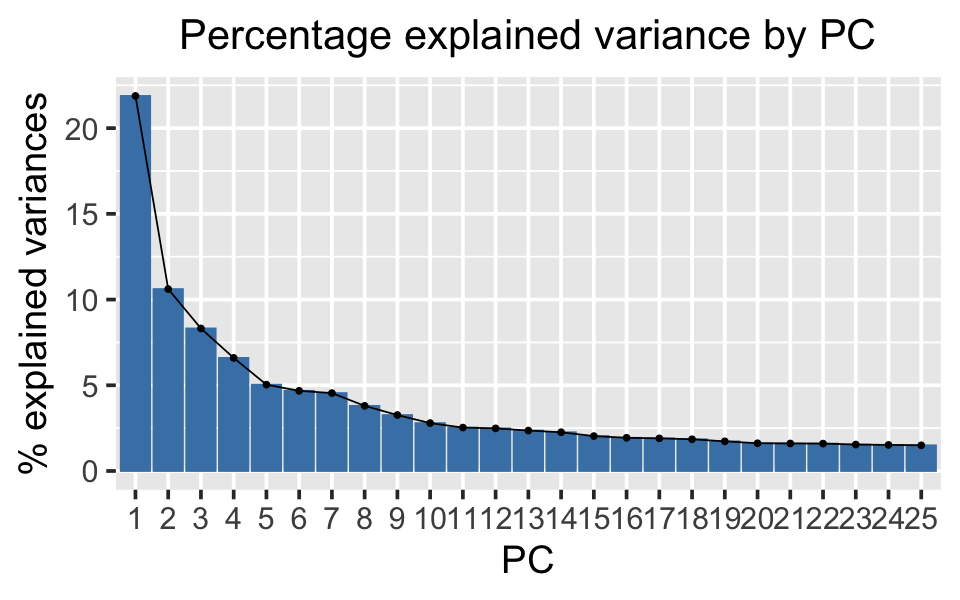

In [353]:
pca_res = prcomp_irlba(scale_exprs %>% t, 25)
rownames(pca_res$x) = colnames(scale_exprs)
rownames(pca_res$rotation) = rownames(scale_exprs)
pcs = pca_res$x
fig.size(5, 8)
p = fviz_screeplot(pca_res, ncp = 25) + theme_g() + ggtitle("Percentage explained variance by PC") + 
        xlab("PC") + ylab("% explained variances")
print(p)
    

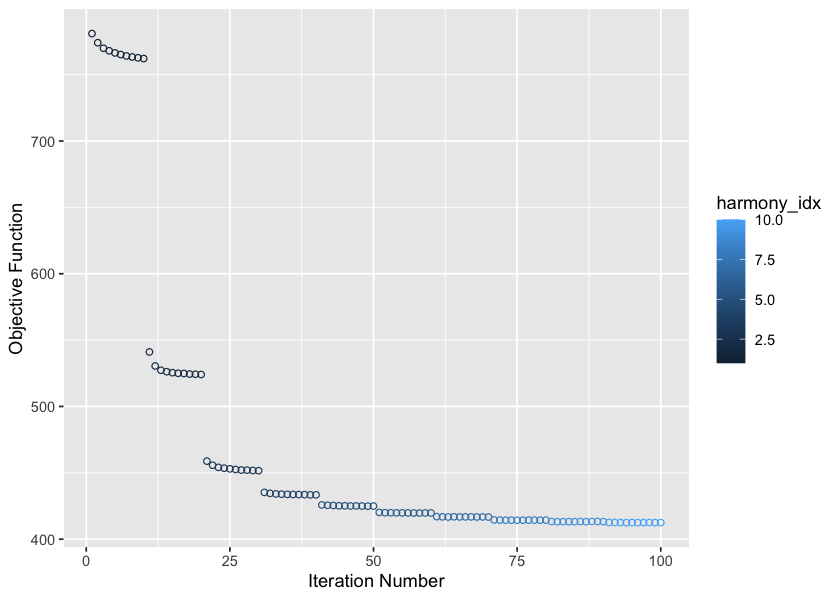

In [361]:
umap_input <- HarmonyMatrix(pcs[, 1:10], full_meta[rownames(pcs),], 
            c("plate", "Run"), 
            plot_convergence = TRUE, max.iter.harmony = 10, epsilon.cluster = -Inf, 
            epsilon.harmony = -Inf, max.iter.cluster = 10, do_pca = F, 
            verbose = F)
umap_res = umap(umap_input)
umap_df = data.frame(umap_res)
colnames(umap_df) = c("UMAP1", "UMAP2")
meta_umap = cbind(full_meta[rownames(umap_df), ], umap_df, umap_input[rownames(umap_df), 
        ])

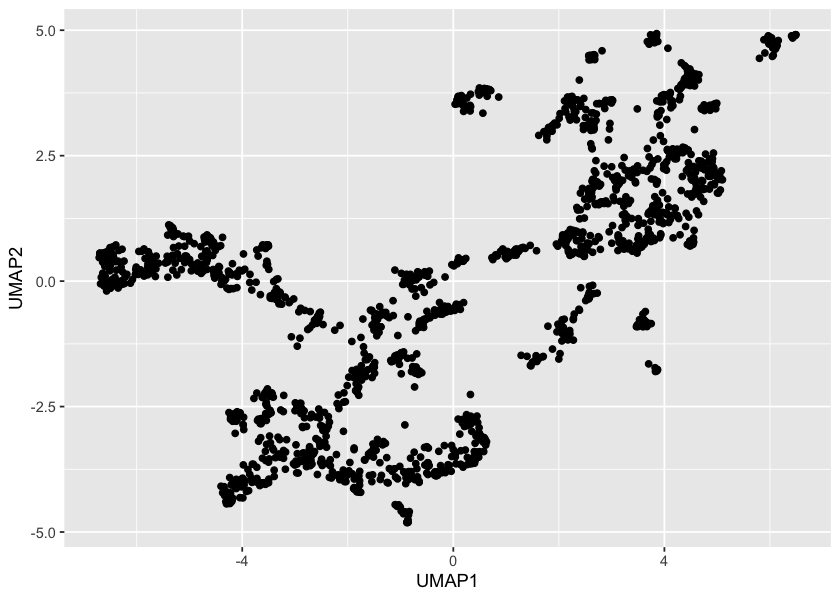

In [362]:
meta_umap %>% ggplot(aes(UMAP1, UMAP2)) + geom_point()

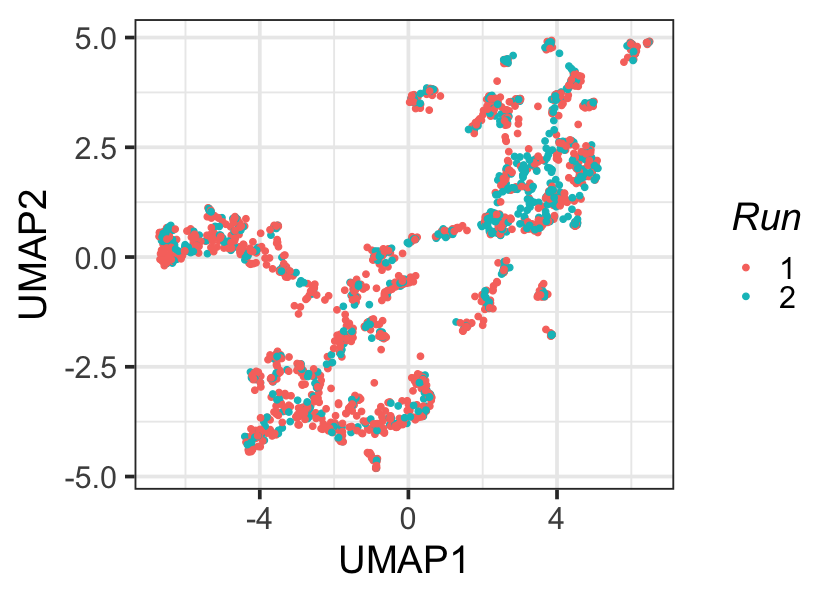

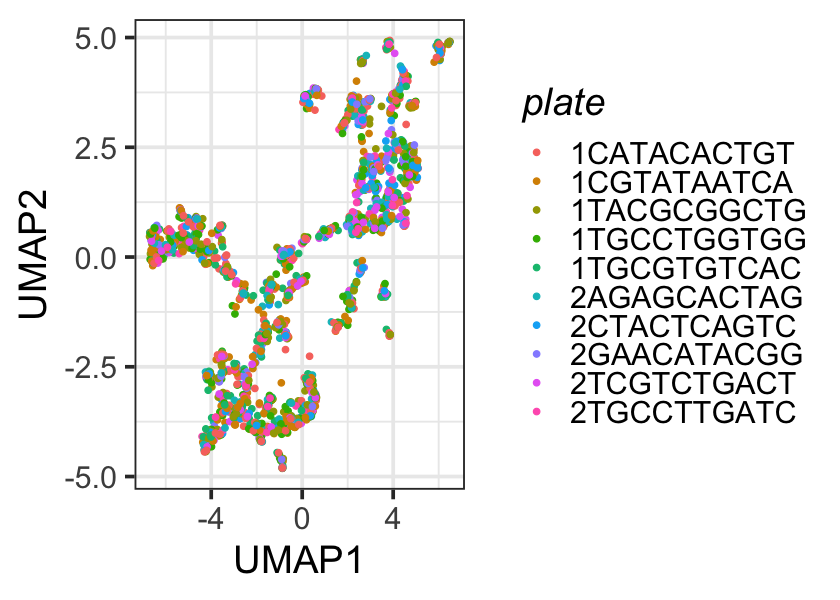

In [363]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Run))+
    theme_gy()

fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()

## ADT

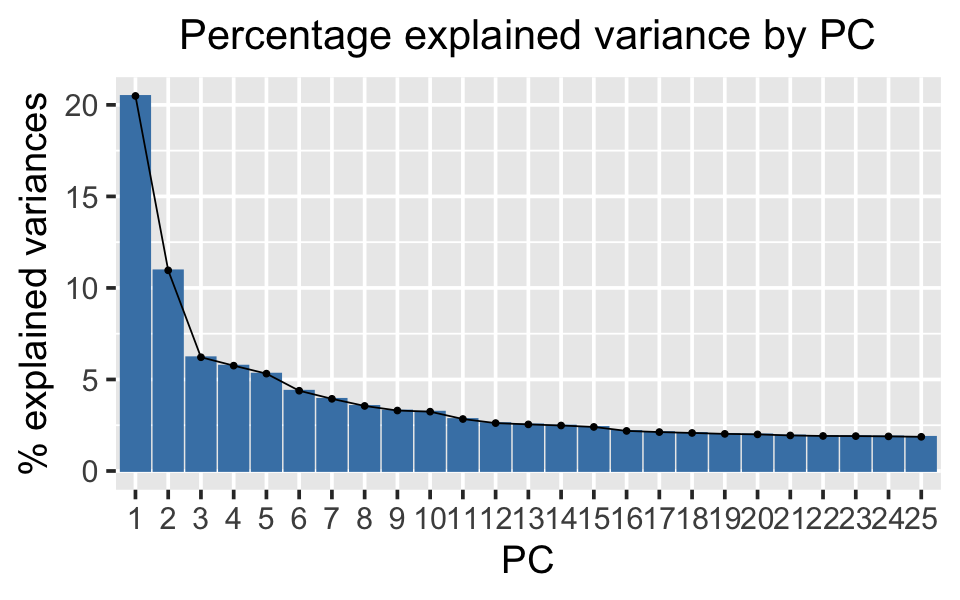

In [364]:
pca_res = prcomp_irlba(scale_adt %>% t, 25)
rownames(pca_res$x) = colnames(scale_adt)
rownames(pca_res$rotation) = rownames(scale_adt)
pcs = pca_res$x
fig.size(5, 8)
p = fviz_screeplot(pca_res, ncp = 25) + theme_g() + ggtitle("Percentage explained variance by PC") + 
        xlab("PC") + ylab("% explained variances")
print(p)
    

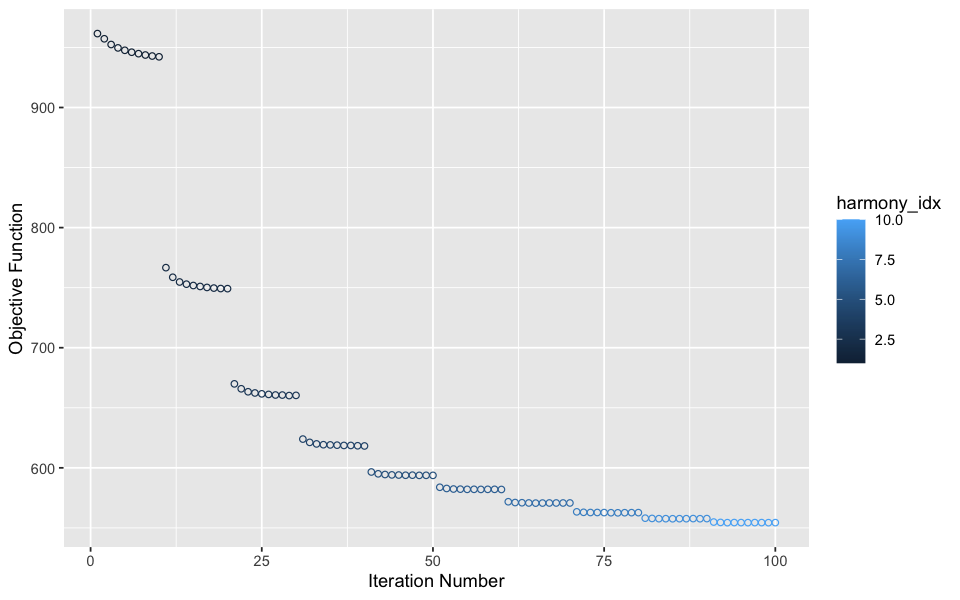

In [366]:
umap_input <- HarmonyMatrix(pcs[, 1:10], full_meta[rownames(pcs),], 
            c("plate", "Run"), 
            plot_convergence = TRUE, max.iter.harmony = 10, epsilon.cluster = -Inf, 
            epsilon.harmony = -Inf, max.iter.cluster = 10, do_pca = F, 
            verbose = F)
umap_res = umap(umap_input)
umap_df = data.frame(umap_res)
colnames(umap_df) = c("UMAP1", "UMAP2")
meta_umap_adt = cbind(full_meta[rownames(umap_df), ], umap_df, umap_input[rownames(umap_df), 
        ])

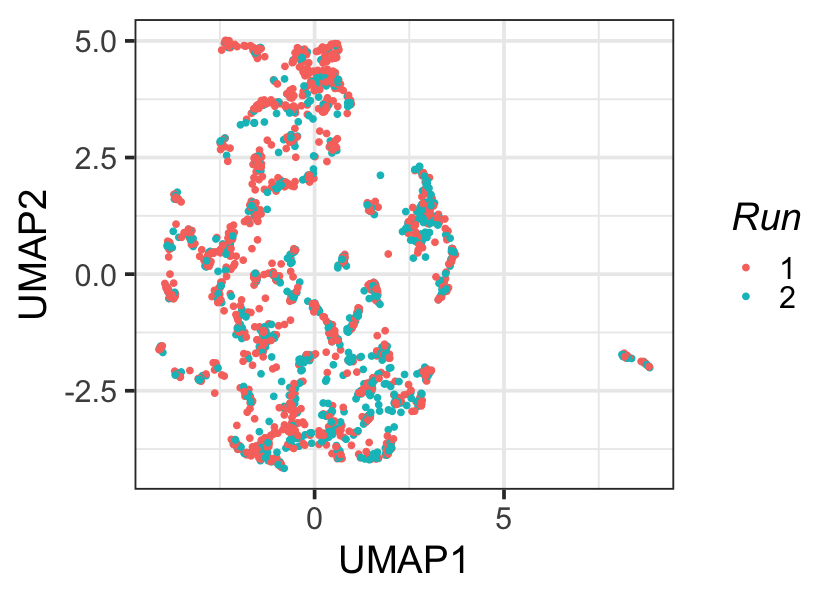

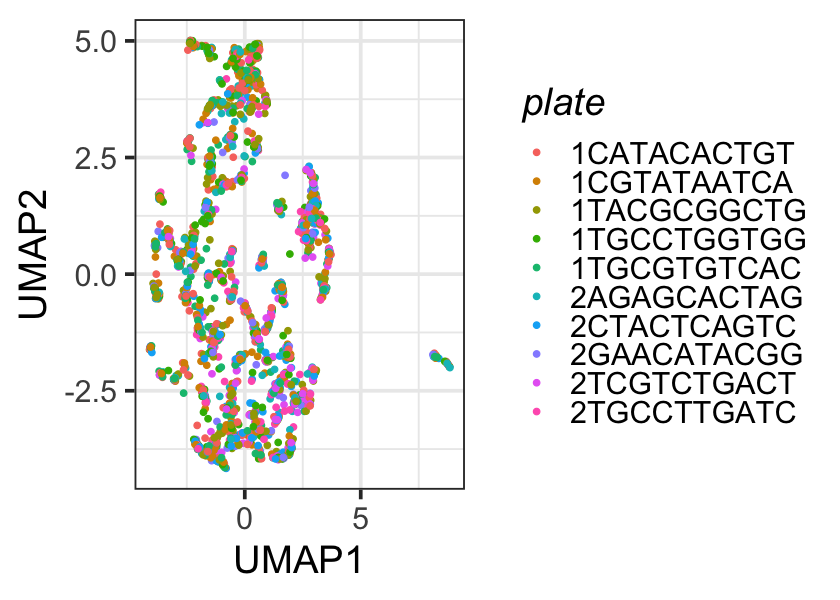

In [367]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Run))+
    theme_gy()

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()

In [368]:
meta_umap %>% write_csv("meta_umap_IL2RAjoint.csv")

In [369]:
meta_umap_adt %>% write_csv("meta_umap_adt_IL2RAjoint.csv")

# Clustering + DGE

In [370]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.05, 0.5, 0.05))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1991
Number of edges: 62748

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9500
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1991
Number of edges: 62748

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9179
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1991
Number of edges: 62748

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8939
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1991
Number of edges: 62748

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8787
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer ver

In [373]:
meta_umap.clust$`res.0.1` %>% table

.
   0    1 
1080  911 

In [374]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

Joining with `by = join_by(cell)`


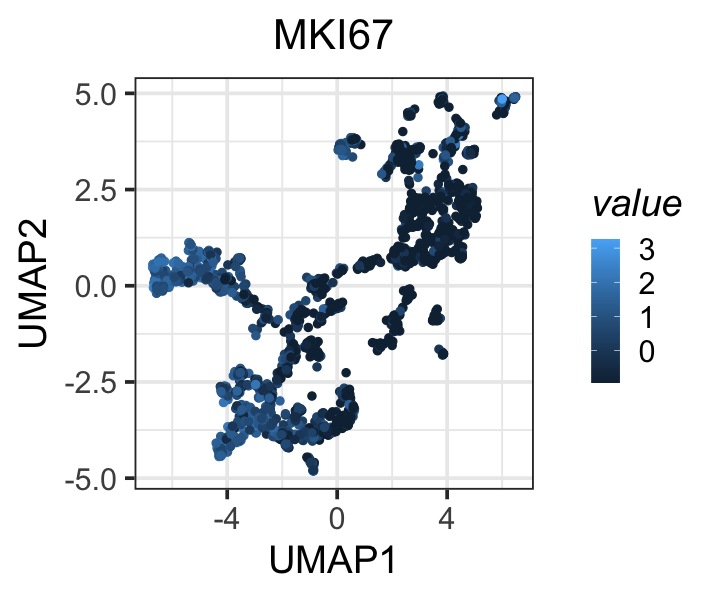

In [375]:
fig.size(5, 6)
scale_exprs["MKI67", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>%

ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = value), size = 2)+
    theme_g(30) + theme_gy() + theme(legend.position = "right") + ggtitle("MKI67")


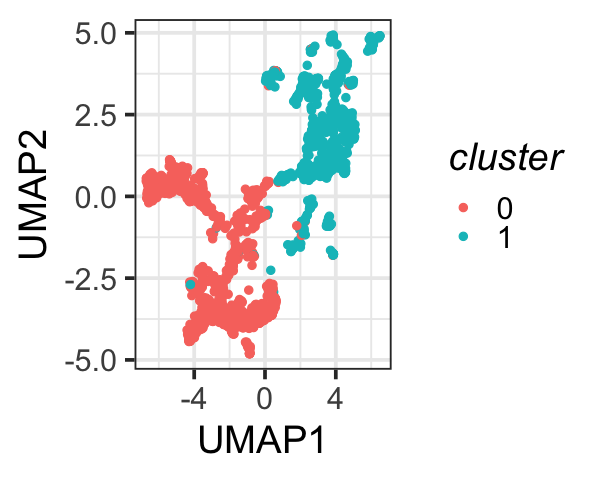

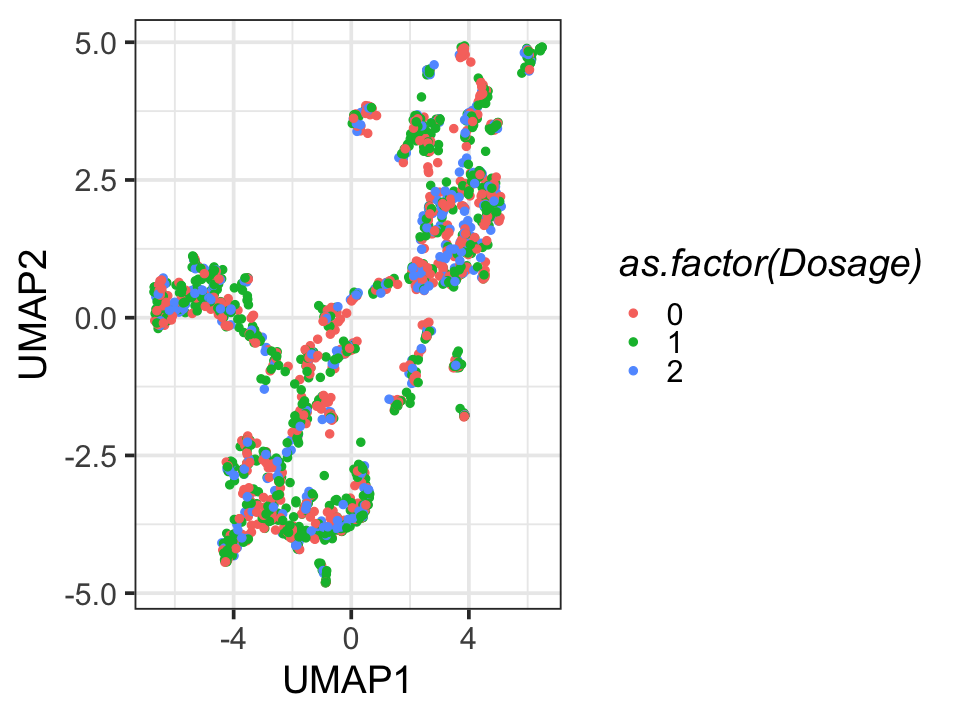

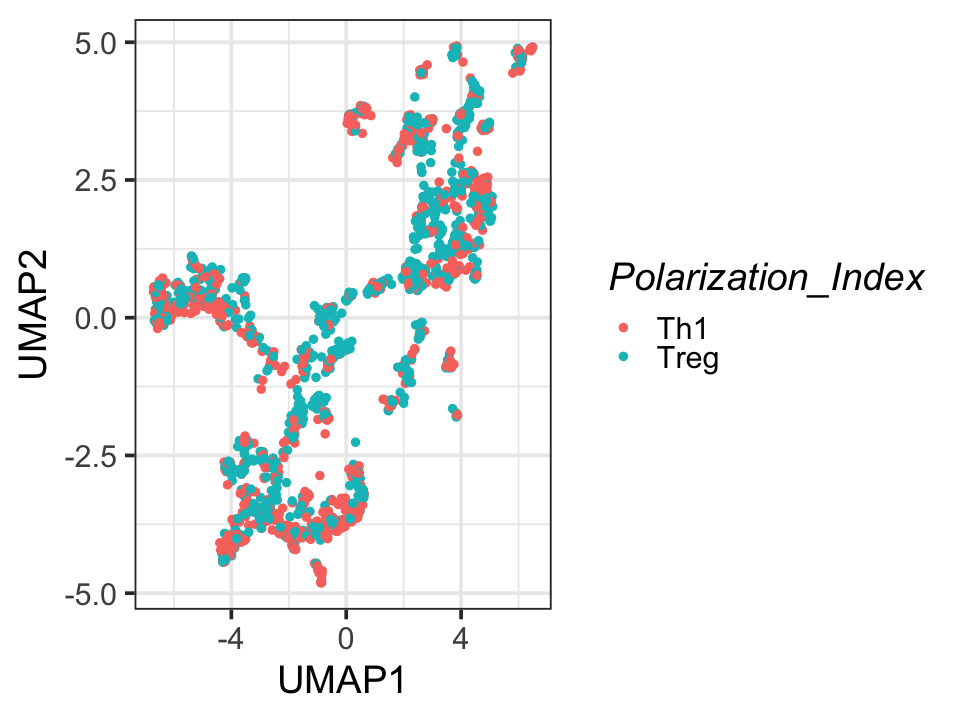

In [376]:
fig.size(4, 5)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30) + theme_gy()

fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = as.factor(Dosage)), size = 2)+
    theme_g(30) + theme_gy()

fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = Polarization_Index), size = 2)+
    theme_g(30) + theme_gy()

In [579]:
df<-meta_umap.clust %>% arrange(cluster)
matrix <- scale_exprs[,df$cell]

dge_CD45 = wilcoxauc(matrix, df$cluster)
var_genes_CD45 = top_markers(dge_CD45, 10) %>% head(10) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(matrix[var_genes_CD45,]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = df$cluster)
rownames(mat_col) <- rownames(df)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(matrix[var_genes_CD45, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(matrix[var_genes_CD45, ])))

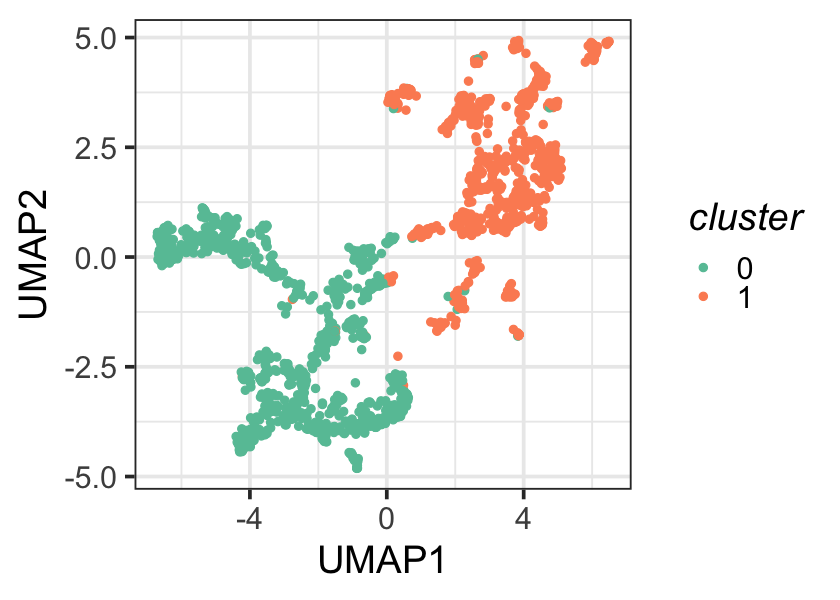

In [585]:
fig.size(5, 7)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30) + theme_gy() + 
scale_color_manual(values = c(`0` = "#66C2A5", 
                               `1` = "#FC8D62" 
                                  #`2` = "#8DA0CB"
                                     ))


Joining with `by = join_by(cell)`


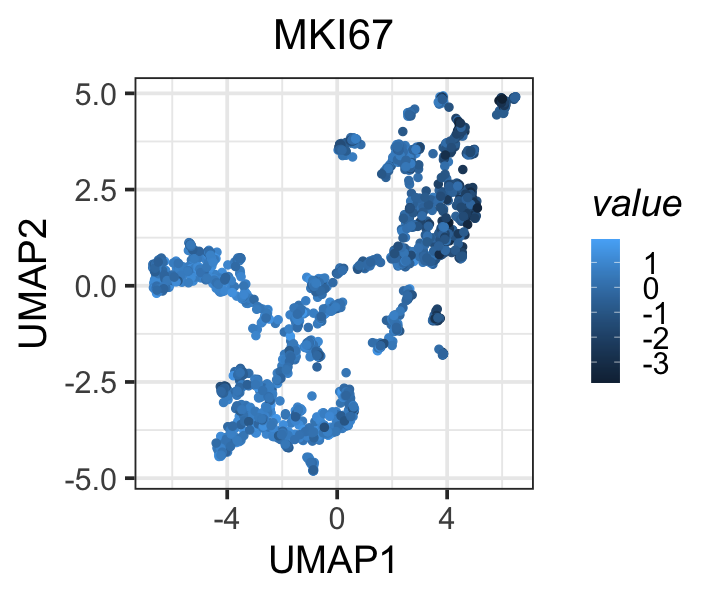

In [587]:
fig.size(5, 6)
scale_exprs["ACTB", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>%

ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = value), size = 2)+
    theme_g(30) + theme_gy() + theme(legend.position = "right") + ggtitle("MKI67")


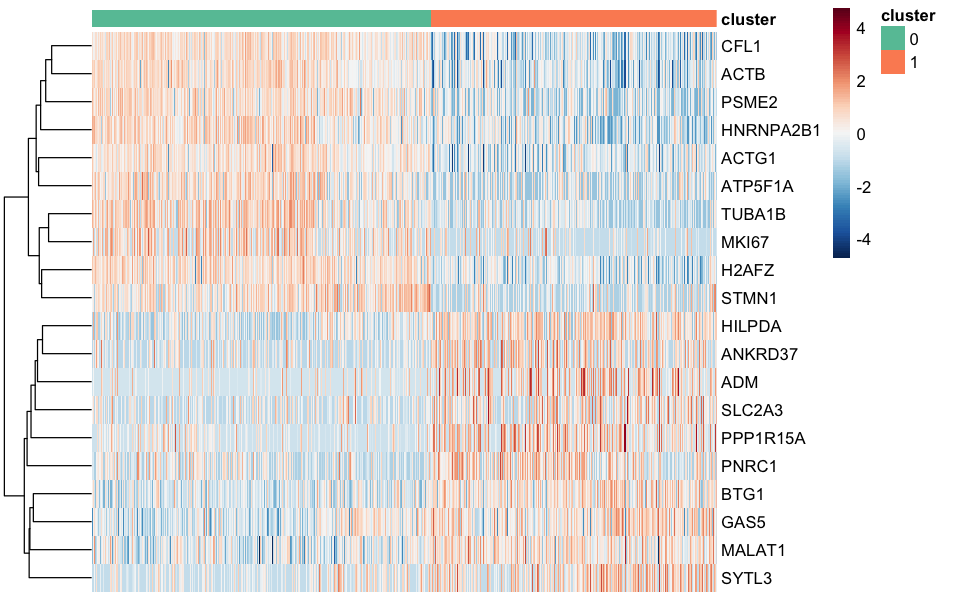

In [588]:
fig.size(5, 8)
g <- pheatmap(as.matrix(matrix[c(var_genes_CD45), df$cell]),
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, 
         fontsize = 10,
         cluster_cols = F,
         annotation_colors = list(cluster = c(
                                  `0` = "#66C2A5", 
                               `1` = "#FC8D62" 
                                  #`2` = "#8DA0CB"
                                     )),
        cluster_rows = mat_cluster_rows,

        )

In [591]:
g %>% ggsave(filename = "IL2RAHeatMap.png", device = "png")

Saving 7 x 7 in image


In [379]:
norm_adt <- normalizeData(full_adt, method = "cellCLR")

Joining with `by = join_by(cell)`


npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4629.717
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4626.071
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4651.303
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4651.974
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2309.859
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2307.036
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4619.717
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4614.071
                                                                                                                                                  Chisq   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5.646111
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                  NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.01749413

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4503.877
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4502.030
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4525.184
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4527.599
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2246.938
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2245.015
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4493.877
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4490.030
                                                                                                                                                  Chisq   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3.847119
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                  NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.04983152

npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4169.106
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4171.069
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4190.433
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4196.661
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2079.553
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2079.534
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4159.106
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4159.069
                                                                                                                                                 Chisq     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                  NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.03734282
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.8467687

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3368.124
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3369.592
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3387.916
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3393.343
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1679.062
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1678.796
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3358.124
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3357.592
                                                                                                                                                 Chisq    
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.5318175
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.4658437

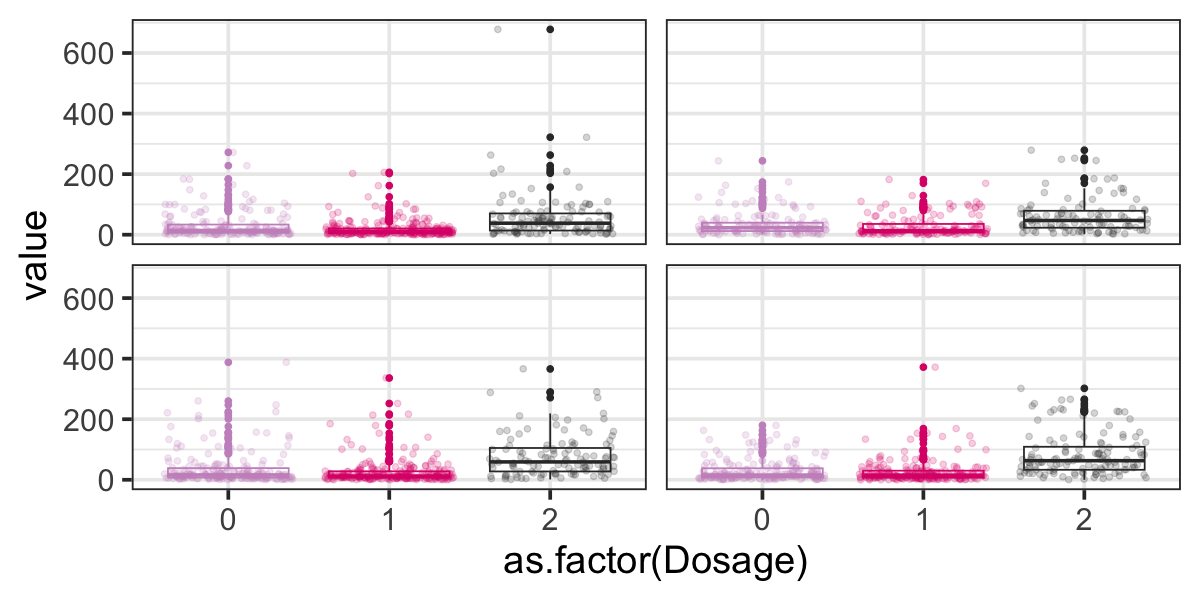

In [603]:
fig.size(5,10)
df <- full_adt["CD25", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>% na.omit()
df %>% 
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) + geom_boxplot()+ geom_jitter(alpha =  0.2)+
facet_grid(Polarization_Index~cluster) + theme_gy() + 
    theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
             
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none')
anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))


 anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))
 

In [605]:
 glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage) %>% summary

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(2.0554)  ( log )
Formula: value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) +  
    Dosage
   Data: filter(df, cluster == 1 & Polarization_Index == "Treg")

     AIC      BIC   logLik deviance df.resid 
  4502.0   4527.6  -2245.0   4490.0      518 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3923 -0.7181 -0.2341  0.5109  5.0960 

Random effects:
 Groups           Name        Variance Std.Dev.
 plate            (Intercept) 0.1404   0.3747  
 Individual_Index (Intercept) 0.3306   0.5750  
Number of obs: 524, groups:  plate, 10; Individual_Index, 5

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.38150    0.64024  -2.158   0.0309 *  
log10(nUMI)  1.14679    0.13464   8.517   <2e-16 ***
Dosage       0.09173    0.04651   1.972   0.0486 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [607]:
full_exprs["ANKRD16", ]

ERROR: Error in intI(i, n = x@Dim[1], dn[[1]], give.dn = FALSE): invalid character indexing


Joining with `by = join_by(cell)`
boundary (singular) fit: see help('isSingular')


boundary (singular) fit: see help('isSingular')




npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5031.813
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5025.437
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5053.399
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5051.340
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2510.907
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2506.718
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5021.813
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5013.437
                                                                                                                                                  Chisq   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 8.376578
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq) 
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                   NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.003800874

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4622.452
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4624.405
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4643.760
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4649.974
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2306.226
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2306.203
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4612.452
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4612.405
                                                                                                                                                  Chisq     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                  NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.04696347
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.8284339

npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4542.437
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4544.373
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4563.764
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4569.964
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2266.219
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2266.186
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4532.437
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4532.373
                                                                                                                                                 Chisq     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                  NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.06439953
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.7996728

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3395.478
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3397.474
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3415.270
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3421.224
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1692.739
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1692.737
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3385.478
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3385.474
                                                                                                                                                 Chisq      
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                   NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.004674616
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.9454902

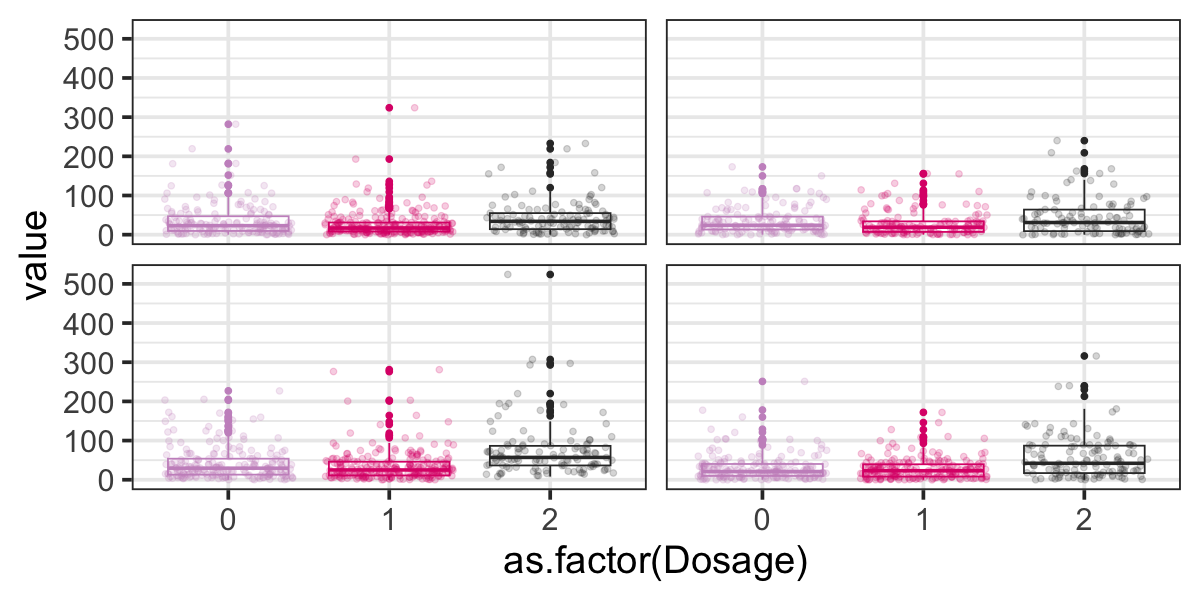

In [608]:
df <- full_exprs["IL2RA", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>% na.omit()
df %>% 
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) + geom_boxplot()+ geom_jitter(alpha =  0.2)+
facet_grid(Polarization_Index~cluster) + theme_gy() + 
    theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
             
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none')
 anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))
 
 anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))
 

In [602]:
 glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage) %>% summary

boundary (singular) fit: see help('isSingular')




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(2.1209)  ( log )
Formula: value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) +  
    Dosage
   Data: filter(df, cluster == 0 & Polarization_Index == "Treg")

     AIC      BIC   logLik deviance df.resid 
  5025.4   5051.3  -2506.7   5013.4      548 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4030 -0.7092 -0.2341  0.5270  5.9592 

Random effects:
 Groups           Name        Variance  Std.Dev. 
 plate            (Intercept) 2.186e-14 1.479e-07
 Individual_Index (Intercept) 6.137e-02 2.477e-01
Number of obs: 554, groups:  plate, 10; Individual_Index, 5

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.60841    0.64162  -8.741  < 2e-16 ***
log10(nUMI)  2.11944    0.14147  14.981  < 2e-16 ***
Dosage       0.12367    0.04255   2.906  0.00366 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1

In [384]:
library(Hmisc)

## Residual Plots

In [595]:
ResidualsPlotADT <- function(data, gene){ 

df <- data[gene, ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>% inner_join(
dplyr::select(full_meta, cell, nUMI_ADT)) %>% na.omit()

#Plotting residuals
#Linear model
ADT_regressed <- glmer.nb(data= df, 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI_ADT))

#Pull residuals and add meta data
Residuals_ADT <- resid(ADT_regressed) %>% as_tibble() %>% 
cbind("Dosage" = df$Dosage, 
      "cluster" = df$cluster, 
      "Polarization" = df$Polarization_Index, 
      "Run" = df$Run, 
         "Individual" = df$Individual_Index, 
     "Plate" = df$plate) 

#Plot
g<- Residuals_ADT %>% 
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) +
facet_grid(Polarization~cluster) +
#stat_summary(fun.data = mean_cl_normal, geom = "errorbar") +  
ylab("Regressed ADT") + 
xlab("Dosage") + theme_gy() + 
geom_boxplot(outlier.shape = NA)+
geom_jitter(alpha = 0.2)+ 
theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none')

return(
plot(g))
}

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell, nUMI_ADT)`


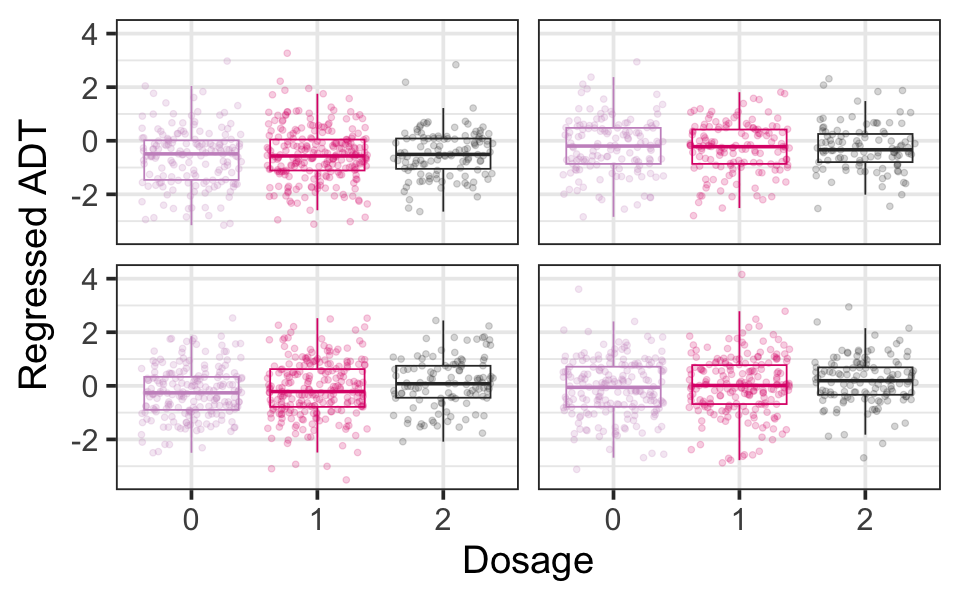

In [596]:
ResidualsPlotADT(full_adt, "CD25")

In [571]:
ResidualsPlot <- function(data, gene){ 

df <- data[gene, ] %>% as_tibble(rownames = "cell") %>% 
    inner_join(meta_umap.clust, by ="cell") %>% inner_join(
    dplyr::select(full_meta, cell, nUMI)) %>% na.omit()

#Plotting residuals
#Linear model
ADT_regressed <- glmer.nb(data= df, 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI))

#Pull residuals and add meta data
Residuals_ADT <- resid(ADT_regressed) %>% as_tibble() %>% 
cbind("Dosage" = df$Dosage, 
      "cluster" = df$cluster, 
      "Polarization" = df$Polarization_Index, 
      "Run" = df$Run, 
         "Individual" = df$Individual_Index, 
     "Plate" = df$plate) 

#Plot
g<- Residuals_ADT %>% 
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) +
facet_grid(Polarization~cluster) +
#stat_summary(fun.data = mean_cl_normal, geom = "errorbar") +  
ylab("Regressed ADT") + 
xlab("Dosage") + theme_gy() + 
geom_boxplot(outlier.shape = NA)+
geom_jitter(alpha = 0.2)+ 
theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none')

return(
plot(g))
}

Joining with `by = join_by(cell, nUMI)`


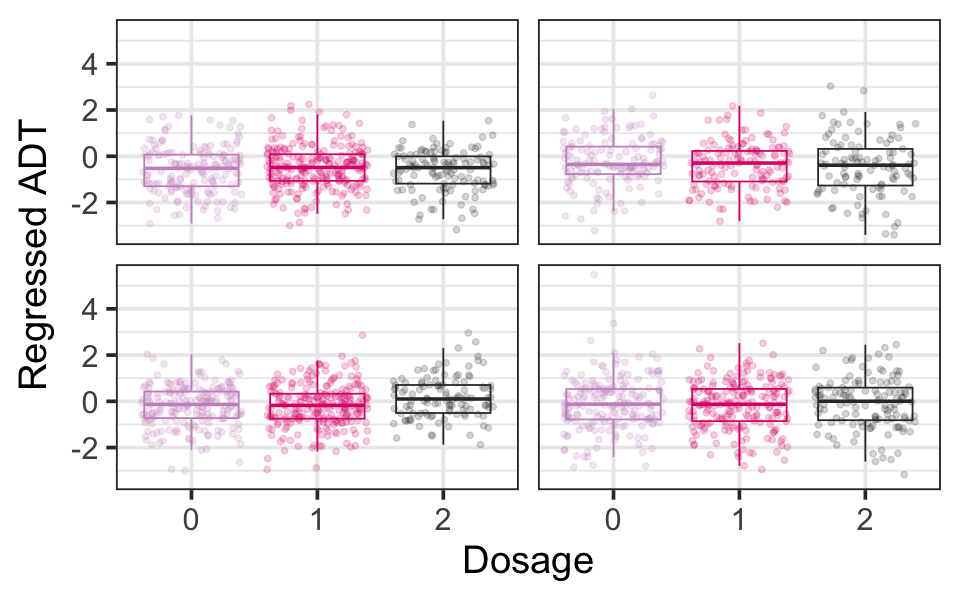

In [593]:
fig.size(5,8)
ResidualsPlot(full_exprs,"IL2RA")

# Linear Modeling ADT


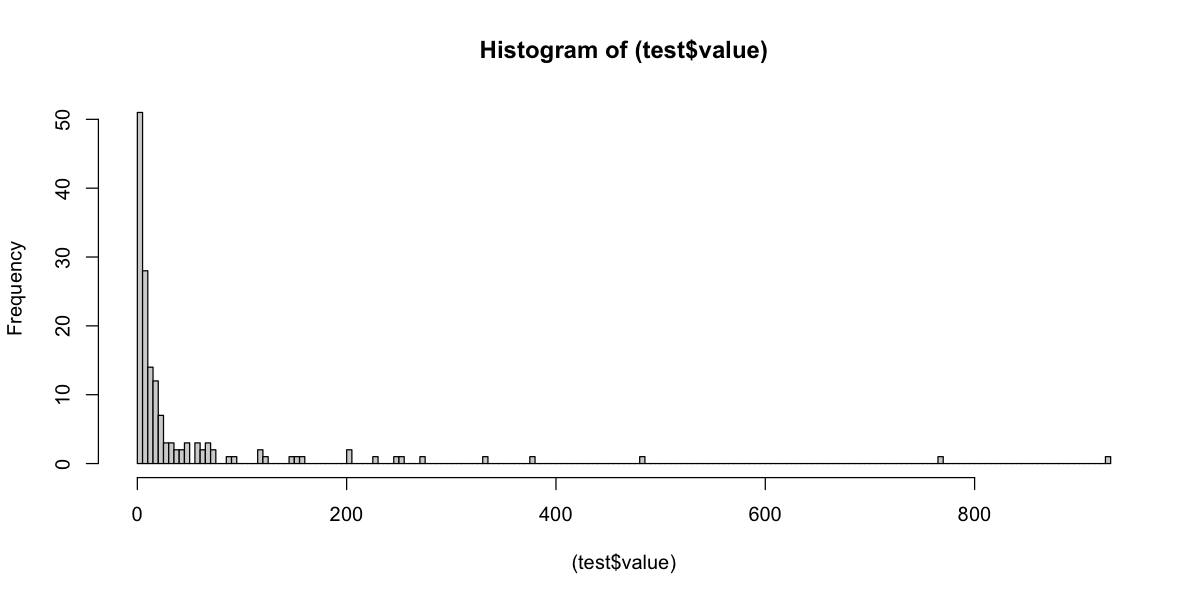

In [402]:
## Need to work out some kind of ADT filtering strategy as the ADTs fail to converge. Some assumptions are broken. 
## Variance is too high to estimate changes for mean expression. 
#Calcuate Variance over Mean (too high indicates that the expression is low and variance is too high)
library(EnvStats) #Load outlier library
test <- (rowVars(as.matrix(full_adt))/ rowMeans(full_adt)  ) %>% as_tibble(rownames = "gene") %>% arrange(-value)
hist((test$value), breaks = length(test$value)) #estimate outliers based on distributions

In [403]:
#set K
outliers <- rosnerTest(test$value, k = 5) %>% with(all.stats) %>% with(Obs.Num) #identify outliers with rosnerTest
genes <- test$gene[-outliers] # remove outliers

## Cluster 0/1 Th1/Treg

In [408]:
## Update full meta
full_meta <- full_meta %>% inner_join(select(meta_umap.clust, cell, cluster))

Joining with `by = join_by(cell)`


In [517]:
# Linear model including a random effect for plate. (lmer)
#Subset Exprs (normalized for lmer)
## In this example, PCS are hurting me. 
###CD86 and HLA are not modeling well. the deviance is too high. Let's remove and try again. 

df <- full_meta %>% filter(cluster == 0& Polarization_Index == "Th1")
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- full_adt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
Th1_0_adt <- 
    map_dfc(genes, possibly(function(i){ 

        

    lm0<- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index), 
            )
    
    lm1 <- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index) + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1, test = "LRT")[2,8]))
       }, NA))
    })
    })

Th1_0_adt<- 
    Th1_0_adt %>% t() %>% as_tibble(rownames = "Gene") %>%
    rename(V1="beta", V2 = "pval") %>% 
    mutate(padj = p.adjust(pval, "BH"))
Th1_0_adt$Gene <- genes

.
  0   1   2 
163 243 120 

[1] 154 526

In [526]:
Th1_0_adt %>% write_csv("Th1_0_adt")

In [530]:
# Th1 cluster 1
# Linear model including a random effect for plate. (lmer)
#Subset Exprs (normalized for lmer)
## In this example, PCS are hurting me. 
###CD86 and HLA are not modeling well. the deviance is too high. Let's remove and try again. 

df <- full_meta %>% filter(cluster == 1& Polarization_Index == "Th1")
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- full_adt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
Th1_1_adt <- 
    map_dfc(genes, possibly(function(i){ 

        

    lm0<- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index), 
            )
    
    lm1 <- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index) + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1, test = "LRT")[2,8]))
       }, NA))
    })
    })

Th1_1_adt<- 
    Th1_1_adt %>% t() %>% as_tibble(rownames = "Gene") %>%
    rename(V1="beta", V2 = "pval") %>% 
    mutate(padj = p.adjust(pval, "BH"))
Th1_1_adt$Gene <- genes
write_csv(Th1_1_adt, "Th1_1_adt.csv")

.
  0   1   2 
140 142 105 

[1] 154 387

In [534]:
# Treg 0

df <- full_meta %>% filter(cluster == 0& Polarization_Index == "Treg")
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- full_adt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
Treg_0_adt <- 
    map_dfc(genes, possibly(function(i){ 

        

    lm0<- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index), 
            )
    
    lm1 <- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index) + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1, test = "LRT")[2,8]))
       }, NA))
    })
    })

Treg_0_adt<- 
    Treg_0_adt %>% t() %>% as_tibble(rownames = "Gene") %>%
    rename(V1="beta", V2 = "pval") %>% 
    mutate(padj = p.adjust(pval, "BH"))
Treg_0_adt$Gene <- genes
write_csv(Treg_0_adt, "Treg_0_adt.csv")

.
  0   1   2 
202 237 115 

[1] 154 554

In [533]:
# Treg 1

df <- full_meta %>% filter(cluster == 1& Polarization_Index == "Treg")
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- full_adt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
Treg_1_adt <- 
    map_dfc(gene, possibly(function(i){ 

        

    lm0<- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index), 
            )
    
    lm1 <- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index) + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1, test = "LRT")[2,8]))
       }, NA))
    })
    })

ç<- 
    Treg_1_adt %>% t() %>% as_tibble(rownames = "Gene") %>%
    rename(V1="beta", V2 = "pval") %>% 
    mutate(padj = p.adjust(pval, "BH"))
Treg_1_adt$Gene <- genes
write_csv(Treg_1_adt, "Treg_1_adt.csv")

.
  0   1   2 
192 203 129 

[1] 154 524

In [545]:
Th1_0_adt %>% arrange(padj) %>% filter(Gene == "CD25")
Th1_1_adt %>% arrange(padj) %>% filter(Gene == "CD25")
Treg_0_adt %>% arrange(padj) %>% filter(Gene == "CD25")
Treg_1_adt %>% arrange(padj) %>% filter(Gene == "CD25")

Gene beta        pval     padj     
1 CD25 0.007807657 0.861666 0.9344436

Gene beta        pval      padj     
1 CD25 -0.00123959 0.9761291 0.9909616

Gene beta      pval       padj     
1 CD25 0.1033473 0.00854521 0.1591545

Gene beta       pval       padj     
1 CD25 0.09320207 0.02044535 0.1847375

## RNA Th1 Treg 0/1

In [612]:
# Th1 1

df <- full_meta %>% filter(cluster == 0& Polarization_Index == "Treg")
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- full_exprs[,df$cell]

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- Exprs[gene_qc %>% filter(nCells > length(df$cell)*0.30) %>% rownames, df$cell] #Expressed in 15% of cells. 
genes <- rownames(Exprs)
Exprs %>% dim

suppressMessages({
    suppressWarnings({
Treg_0_RNA <- 
    map_dfc(genes[1:10], possibly(function(i){ 

        

    lm0<- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI) + (1|plate) + (1|Individual_Index), 
            )
    
    lm1 <- glmer.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI_ADT) + (1|plate) + (1|Individual_Index) + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1, test = "LRT")[2,8]))
       }, NA))
    })
    })

Treg_0_RNA<- 
    Treg_0_RNA %>% t() %>% as_tibble(rownames = "Gene") %>%
    rename(V1="beta", V2 = "pval") %>% 
    mutate(padj = p.adjust(pval, "BH"))
Treg_0_RNA$Gene <- genes[1:10]
write_csv(Treg_0_RNA, "Treg_0_RNA.csv")

.
  0   1   2 
202 237 115 

[1] 4565  554

In [624]:
lm0<- glmer.nb(data = df,  
          formula = (Exprs)["IL2RA",] ~ 1 + log10(nUMI) + (1|plate) + (1|Individual_Index), 
            )
    
    lm1 <- glmer.nb(data = df,  
          formula = (Exprs)["IL2RA",] ~ 1  + log10(nUMI) + (1|plate) + (1|Individual_Index) + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1, test = "LRT")[2,8]))

boundary (singular) fit: see help('isSingular')


boundary (singular) fit: see help('isSingular')




[1] 0.123670667 0.003800874

In [625]:
lm0<- glm.nb(data = df,  
          formula = (Exprs)["IL2RA",] ~ 1 + log10(nUMI) + plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)["IL2RA",] ~ 1  + log10(nUMI) + plate + Individual_Index + Dosage, 
               )
     return(c(summary(lm1)$coefficients[3,1], 
            anova(lm0,lm1)[2,8]))

[1] -0.01562318  0.01661284

In [623]:
summary(lm1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(1.7987)  ( log )
Formula: (Exprs)["IL2RA", ] ~ 1 + log10(nUMI_ADT) + (1 | plate) + (1 |  
    Individual_Index) + Dosage
   Data: df

     AIC      BIC   logLik deviance df.resid 
  5126.0   5151.9  -2557.0   5114.0      548 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3026 -0.7557 -0.1915  0.4046  5.2231 

Random effects:
 Groups           Name        Variance Std.Dev.
 plate            (Intercept) 0.05023  0.2241  
 Individual_Index (Intercept) 0.01692  0.1301  
Number of obs: 554, groups:  plate, 10; Individual_Index, 5

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.82784    0.47322  -1.749   0.0802 .  
log10(nUMI_ADT)  1.31379    0.13126  10.009   <2e-16 ***
Dosage           0.08150    0.04644   1.755   0.0793 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fix

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell, nUMI_ADT)`


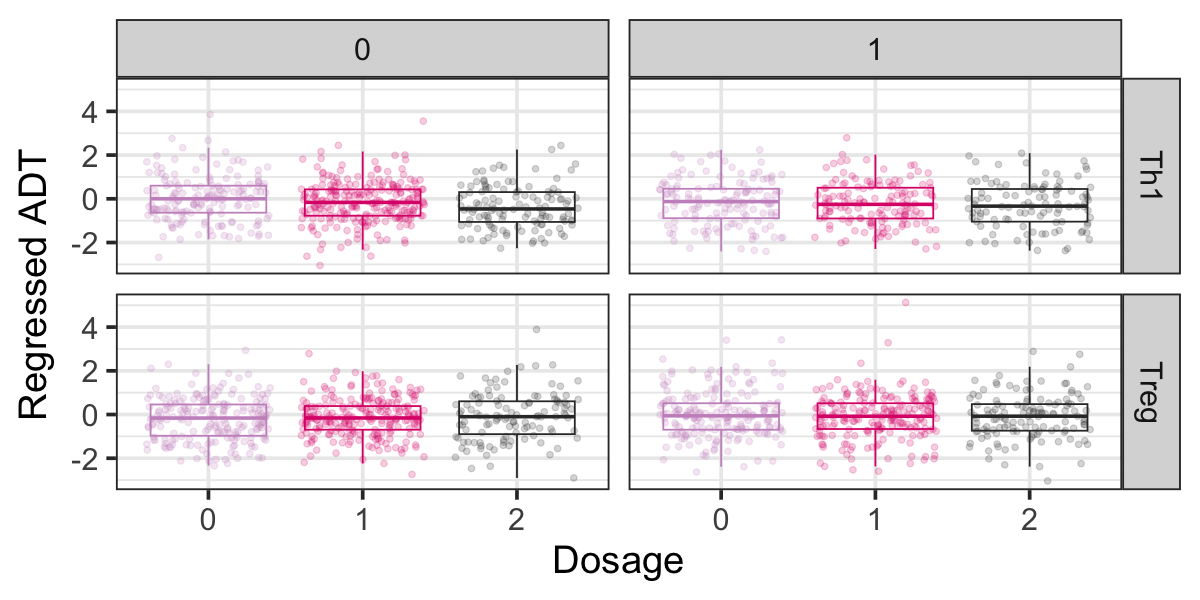

In [525]:
ResidualsPlotADT(full_adt, "TIGIT")

Exprs <- exprs[, df$cell] #expression in this set of cells

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.15) %>% rownames, cells] #Expressed in 15% of cells. 
genes <- rownames(Exprs)
Exprs %>% dim

# DNA plot

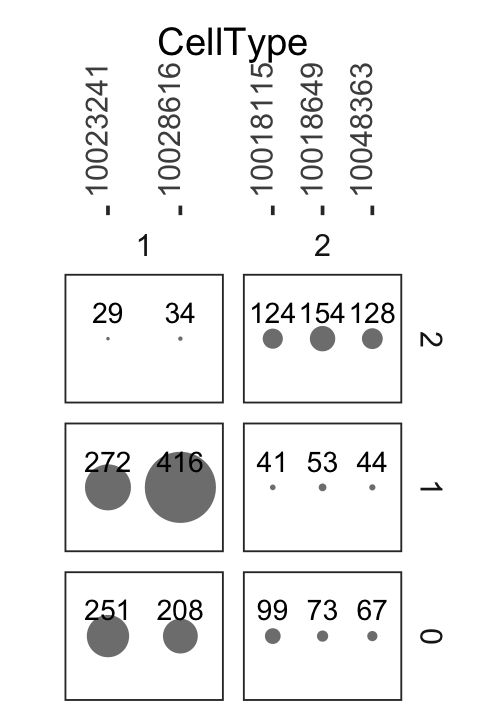

In [1177]:
## Plot of PTEN genotypes distributions across RNA clusters
## Define df for plotting 
test2 <- full_meta %>% add_count(genotype,name = "genotype_count") %>% 
    filter(genotype_count  > 10)

#Defineplotting Order
order <- test2$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,4)
g <- 

table(test2$Dosage,test2$Individual_Index, test2$Run) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1, Run = Var3) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =6, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor(genotype, levels = c(2,1,0))~ Run, scales="free") + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) +scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))
    
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "IL2RA.png", device = "png", dpi = 300, width = 3, height = 6)
    })